In [ ]:
# TODO: da fare ancora
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
from torch import nn
torch.backends.cudnn.benchmark = False
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset

import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [ ]:
class MoviesDataset(Dataset):
    def __init__(self):
        df = pd.read_csv("script_slurm/df.csv")
        df = self.cleaning(df)

        X, y, weights = self.split_XYweights(df)
        
        y = self.discretization(y)
        X.drop('rating_mean', inplace=True, axis=1)

        self.num_classes = y.nunique()
        self.X = torch.FloatTensor(X.values)
        self.y = torch.LongTensor(y)
        self.weights = torch.FloatTensor(weights)


    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx], self.weights[idx]

    def split_XYweights(self, df):
        y = df['rating_mean']
        weights = df['ratings_count']
        X = df.drop(columns=['ratings_count'], axis=1)
        return X, y, weights

    def cleaning(self, df):
        df.dropna(subset=['rating_mean'], inplace=True)
        df_without_tags = df[df.iloc[:, 23:-2].isna().all(axis = 1)]
        df_without_tags_nor_genres = df_without_tags[
            df_without_tags['(no genres listed)'] == 1]
        rows_to_be_deleted = df.loc[df["movieId"].isin(
            df_without_tags_nor_genres["movieId"])].index
        df.drop(rows_to_be_deleted, axis=0, inplace=True)
        df.iloc[:, 23:-2] = df.iloc[:, 23:-2].fillna(0)
        df.drop(['(no genres listed)'], inplace=True, axis=1)
        df_year_without_na = df.year[-pd.isna(df.year)]
        df.year = df.loc[:, 'year'].fillna(
            np.median(df_year_without_na)).astype('int')
        df.drop('movieId', inplace=True, axis=1)
        df.drop_duplicates(inplace=True)
        return df

    def discretization(self, series):
        series = pd.cut(series, bins=5, labels=False)
        return series


In [ ]:
class Feedforward(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        dropout = 0.2
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            # nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(),
            # nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size),
            # nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(),
            # nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, num_classes),
            #nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)


def train_model(model, criterion, optimizer, epochs, data_loader, device):
    model.train()
    loss_values = []
    for epoch in range(epochs):
        for batch_idx, samples in enumerate(data_loader):
            data, targets = samples[0].to(device), samples[1].to(device)
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(data)

            # Compute Loss
            loss = criterion(y_pred.squeeze(), targets)
            loss_values.append(loss.item())
            # print('Epoch {} train loss: {}'.format(epoch, loss.item()))

            # Backward pass
            loss.backward()
            optimizer.step()

    return model, loss_values


def test_model(model, data_loader, device):
    model.eval()
    y_pred = []
    y_test = []

    for batch_idx, samples in enumerate(data_loader):
        data, targets = samples[0].to(device), samples[1].to(device)
        y_pred.append(model(data))
        y_test.append(targets)
    y_pred = torch.stack(y_pred).squeeze()
    y_test = torch.stack(y_test).squeeze()
    y_pred = y_pred.argmax(dim=1, keepdim=True).squeeze()
    print(classification_report(y_test.cpu(), y_pred.cpu(), zero_division=0))


In [ ]:
#if __name__ == "__main__":
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: {}".format(device))

torch.manual_seed(42)
np.random.seed(42)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.use_deterministic_algorithms(False)

hidden_size = 10
num_epochs = 100
batch = 256
learning_rate = 0.01

dataset = MoviesDataset()
train_idx, test_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, stratify=dataset.y, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, stratify=dataset.y[train_idx], random_state=42)

# MinMaxScale training, validation and testing set su year e title_length
X_train = dataset.X[train_idx]
X_val = dataset.X[val_idx]
X_test = dataset.X[test_idx]

train_year_max = torch.max(X_train[:,1])
train_year_min = torch.min(X_train[:,1])
dataset.X[train_idx, 1] = (X_train[:,1] - train_year_min)/(train_year_max - train_year_min)
dataset.X[val_idx, 1] = (X_val[:,1] - train_year_min)/(train_year_max - train_year_min)
dataset.X[test_idx, 1] = (X_test[:,1] - train_year_min)/(train_year_max - train_year_min)

train_title_length_max = torch.max(X_train[:,2])
train_title_length_min = torch.min(X_train[:,2])
dataset.X[train_idx, 2] = (X_train[:,2] - train_title_length_min)/(train_title_length_max - train_title_length_min)
dataset.X[val_idx, 2] = (X_val[:,2] - train_title_length_min)/(train_title_length_max - train_title_length_min)
dataset.X[test_idx, 2] = (X_test[:,2] - train_title_length_min)/(train_title_length_max - train_title_length_min)


# Creating sampler to manage unbalancing classes
def class_weights(y):
    class_count = torch.bincount(y)
    class_weighting = 1. / class_count
    sample_weights = class_weighting[y]   # sarebbe np.array([weight[t] for t in y_train])
    return sample_weights

y_train = dataset.y[train_idx]

sample_weights = class_weights(y_train)
sampler_class_frequency = WeightedRandomSampler(sample_weights, len(train_idx))

# MinMaxScaling ratings_count
weights_train = dataset.weights[train_idx] 
weights_val = dataset.weights[val_idx]
weights_test = dataset.weights[test_idx] 

weights_train_max = torch.max(weights_train)
weights_train_min = torch.min(weights_train)
dataset.weights[train_idx]  = (weights_train - weights_train_min) / (weights_train_max - weights_train_min)
dataset.weights[val_idx] = (weights_val - weights_train_min) / (weights_train_max - weights_train_min)
dataset.weights[test_idx] = (weights_test - weights_train_min) / (weights_train_max - weights_train_min)

sampler_ratings_count = WeightedRandomSampler(dataset.weights[train_idx], len(train_idx))

train_subset = Subset(dataset, train_idx)
val_subset = Subset(dataset, val_idx)
test_subset = Subset(dataset, test_idx)

train_loader = DataLoader(train_subset, batch_size=batch, shuffle=False, sampler=sampler_ratings_count, drop_last=True)
val_loader = DataLoader(val_subset, batch_size=1, shuffle=False, drop_last=True)
test_loader = DataLoader(test_subset, batch_size=1, shuffle=False, drop_last=True)

Device: cuda


In [ ]:
for i, samples in enumerate(train_loader):
    print(len(np.where(samples[1].numpy() == 0)[0]),
        len(np.where(samples[1].numpy() == 1)[0]),
        len(np.where(samples[1].numpy() == 2)[0]),
        len(np.where(samples[1].numpy() == 3)[0]),
        len(np.where(samples[1].numpy() == 4)[0]), sep = "\t"
    )

0	4	49	187	16
0	8	56	180	12
1	3	54	176	22
0	3	56	182	15
0	3	40	188	25
0	2	51	189	14
0	4	57	178	17
0	3	48	188	17
0	6	46	191	13
0	5	53	186	12
0	5	46	182	23
0	3	56	181	16
0	0	43	200	13
0	5	43	190	18
0	5	59	173	19
0	4	50	186	16
0	3	48	186	19
0	4	54	180	18
0	5	54	184	13
0	3	50	188	15
0	4	55	184	13
0	4	53	179	20
0	5	56	182	13
0	2	45	192	17
0	1	54	178	23
0	4	46	193	13
0	1	51	190	14
0	7	48	183	18
0	6	46	185	19
0	4	58	175	19
0	2	44	193	17
0	4	47	188	17
0	4	46	189	17
0	6	64	168	18
0	2	63	170	21
0	4	47	182	23
0	3	52	184	17
0	2	54	183	17
0	1	39	201	15
0	1	62	175	18
0	3	52	184	17
1	3	43	194	15
0	10	39	190	17
0	5	52	182	17
0	3	50	189	14
0	2	59	178	17
0	5	57	179	15
0	3	47	188	18
0	6	44	177	29
0	5	41	197	13
0	3	48	193	12
0	2	49	189	16
0	4	50	181	21
0	3	68	172	13
0	4	54	181	17
0	3	64	168	21
0	5	58	179	14
1	7	59	172	17
0	4	51	182	19
0	3	63	177	13
0	2	51	188	15
0	3	48	186	19
0	3	53	185	15
1	4	62	173	16
0	3	49	182	22
0	5	51	183	17
0	5	52	187	12
0	1	50	181	24
0	1	47	193	15
0	2	48	182	24
0	2	42	189	23
1	6	4

              precision    recall  f1-score   support

           0       0.03      1.00      0.06       311
           1       0.02      0.00      0.00      1117
           2       0.00      0.00      0.00      4265
           3       0.00      0.00      0.00      4691
           4       0.00      0.00      0.00       394

    accuracy                           0.03     10778
   macro avg       0.01      0.20      0.01     10778
weighted avg       0.00      0.03      0.00     10778

              precision    recall  f1-score   support

           0       0.05      0.27      0.08       311
           1       0.00      0.00      0.00      1117
           2       0.44      0.19      0.26      4265
           3       0.52      0.46      0.49      4691
           4       0.07      0.54      0.12       394

    accuracy                           0.30     10778
   macro avg       0.21      0.29      0.19     10778
weighted avg       0.40      0.30      0.32     10778



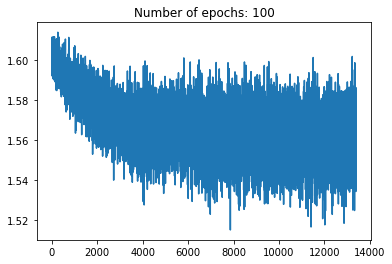

In [ ]:
model = Feedforward(dataset.X.shape[1], hidden_size, dataset.num_classes)
criterion = torch.nn.CrossEntropyLoss() #(weight = torch.Tensor([1,0.8,0.3,0.2,0.9]).cuda())
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
model.to(device)
test_model(model, test_loader, device)
model, loss_values = train_model(model, criterion, optimizer, num_epochs, train_loader, device)
test_model(model, test_loader, device)
plt.plot(loss_values)
plt.title("Number of epochs: {}".format(num_epochs))
plt.show()

In [ ]:
def predict(row, model):
    row = torch.Tensor([row])
    yhat = model(row)
    yhat = yhat.detach().numpy()
    return yhat